<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2022-1/notebooks/3a_transfer_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de grano fino empleando transferencia de conocimiento

Curso: [Aprendizaje Profundo](http://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_profundo/). Profesor: [Gibran Fuentes Pineda](http://turing.iimas.unam.mx/~gibranfp/). Ayudantes: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/).

---
---

En esta libreta veremos un ejemplo sencillo pero completo para clasificación de flores sobre el conjunto [17 Flowers](http://www.robots.ox.ac.uk/~vgg/data/flowers/17/) usando transferencia de conocimiento. El conjunto está formado por 1360 imágenes donde cada una pertenece uno de los 17 tipos de flores. El conjunto provee 3 particiones distintas con 40, 20 y 20 ejemplos de cada flor para entrenamiento, validación y prueba respectivamente. 

En particular vamos a repasar:

* conjuntos y cargadores,
* aumentado de datos/transformaciones,
* transferencia de conocimiento con [Shufflenet V2](https://arxiv.org/abs/1807.11164),
* protocolo de entrenamiento y evaluación,
* monitoreo del entrenamiento,
* pseudo paro temprano y
* guardado y carga modelos.


<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2022-1/figs/flowers17.svg" width="950" height="750" />

## 1. Preparación

In [1]:
# Colab
! pip install torchinfo

### 1.1 Bibliotecas

In [2]:
# marcas de tiempo
import datetime
# explorar el sistema de archivos
import glob
# sistema de archivos
import os
# funciones aleatorias
import random
# marcas de tiempo
import time
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
from os.path import join

# gráficas
import matplotlib.patches as patches
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
import torchvision.models as tvm
import torchvision.transforms as T
# leer archivo matlab
from scipy.io import loadmat
# cargador de datos
from torch.utils.data import DataLoader
# trazas de Tensorboard
from torch.utils.tensorboard import SummaryWriter
# inspección de arquitectura
from torchinfo import summary
# barra de progreso
from tqdm.notebook import trange
# imágenes
from PIL import Image

### 1.2. Auxiliares

In [3]:
# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# tamaño de la imagen
IMG_SIZE = 224

# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# filas y columnas de la cuadrícula 
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Despliega un ejempos en una cuadrícula."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos lote
    display_grid(x, titles, rows, cols, figsize)


def timestamp(fmt='%y%m%dT%H%M%S'):
    """Regresa la marca de tiempo."""
    return datetime.datetime.fromtimestamp(time.time()).strftime(fmt)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# reproducibilidad
set_seed()

## 2. Datos

### 2.1 Tuberias de datos con PyTorch

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2022-1/figs/comida_datos.svg" width="950" height="750" />

### 2.2 Conjunto de datos

In [4]:
class Flowers17:

    def __init__(self, root, split, subset, 
                 transform=None, download=False):
        
        # validamos argumentos
        if split not in {1, 2, 3}:
            ValueError(f'invalid value for split={split}')
        if subset not in {'trn', 'val', 'tst'}:
            ValueError(f'invalid value for subset={subset}')
        
        # guardamos atributos
        self.root = join(root, 'flowers17')
        self.split = split
        self.subset = subset
        self.transform = transform

        # creamos directorio raíz
        os.makedirs(self.root, exist_ok=True)

        # descargados datos
        if download:
            self.download()

        # verificamos integridad
        if not self._check_integrity():
            raise RuntimeError(
                'Dataset not found or corrupted.'
                ' You can use download=True to download it')

        # cargamos partición y subconjunto
        mat = loadmat(join(self.root, 'datasplits.mat'))
        self.x = mat[f'{subset}{split}'][0]

        # leemos las clases y sus números de ejemplos
        df = pd.read_csv(join(self.root, 'classes.csv'))

        # guardamos etiquetas como int
        y = [np.repeat(i, n) for i, n 
             in enumerate(df['examples'])]
        self.y = np.concatenate(y)
  
        # guardamos etiquetas como str
        self.labels = {i: clazz for i, clazz 
                       in enumerate(df['class'])}

    def __getitem__(self, i):
        # cargamos la imagen
        x = self.x[i]
        path = join(self.root, 'jpg', f'image_{x:04d}.jpg')
        img = Image.open(path)
        # aplicamos transformación
        if self.transform is not None:
            img = self.transform(img)
        # leemos la etiqueta como int
        y = self.y[x-1]
        # leemos la etiqueta como str
        label = self.labels[y]
        # regresamos ejemplo como dict
        return {'x': img, 'y': y, 'label': label}

    def __len__(self):
        # regresamos numeros de ejemplos
        return len(self.x)

    def _check_integrity(self):
        return os.path.exists(join(self.root, 'jpg'))
    
    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        tvu.download_and_extract_archive(
            url='https://cloud.xibalba.com.mx/s/kG4xHfdGXF3jfiy/download',
            download_root=self.root,
            filename='flowers17.tar.gz',
            md5='8a0e60b25cb39991eda100b66aa57e0a'
        )

In [5]:
ds = Flowers17(DATA_DIR, 1, 'trn', download=True)

  0%|          | 0/60326109 [00:00<?, ?it/s]

Extracting ../data/flowers17/flowers17.tar.gz to ../data/flowers17


In [6]:
len(ds)

680

Imagen dimensiones=(500, 603) tipo=<class 'PIL.JpegImagePlugin.JpegImageFile'>
Etiqueta int=9 str=Sunflower


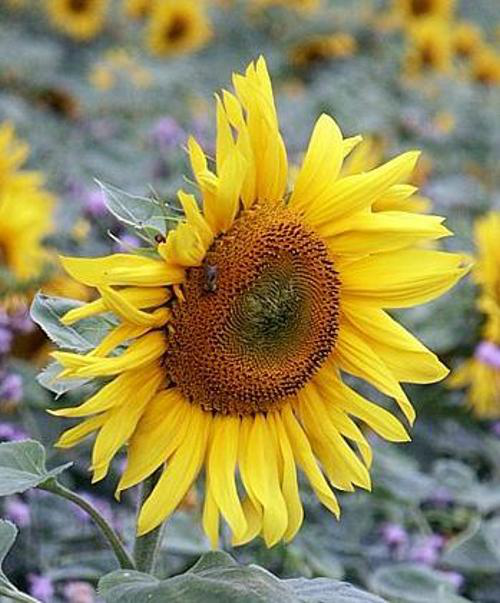

In [7]:
example = ds[360]
x, y, label = example['x'], example['y'], example['label']
print(f'Imagen dimensiones={x.size} tipo={type(x)}')
print(f'Etiqueta int={y} str={label}')
example['x']

### 2.3 Transformaciones

Torchvision tiene un conjunto de [transformaciones](https://pytorch.org/docs/1.6.0/torchvision/transforms.html) para ser ejecutadas de forma secuencial cuando se la pasamos a la clase `Compose`.

In [8]:
# transformación de entrenamiento
trn_tsfm = T.Compose([
    # redimensionamos a Wx224 o 224xH
    T.Resize(IMG_SIZE),
    # cortamos al centro 224x224
    T.CenterCrop(IMG_SIZE),
    # aumentado de datos
    # espejeo horizontal aleatorio
    T.RandomHorizontalFlip(),
    # convertimos a torch.Tensor [3,H,W]
    # escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# conjunto
trn_ds = Flowers17(DATA_DIR, 1, 'trn', transform=trn_tsfm)

In [9]:
# transformación de validación
val_tsfm = T.Compose([
    # redimensionamos a Wx224 o 224xH
    T.Resize(IMG_SIZE),
    # cortamos al centro 224x224
    T.CenterCrop(IMG_SIZE),
    # convertimos a torch.Tensor [3,H,W]
    # escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
# conjunto
val_ds = Flowers17(DATA_DIR, 1, 'val', transform=val_tsfm)

### 2.4 Cargadores de datos

Los [cargadores de datos](https://pytorch.org/docs/1.6.0/data.html) pueden precargar el siguiente lote de de entrenamiento forma paralela si especificamos `num_workers => 2`.

<img src="https://github.com/gibranfp/CursoAprendizajeProfundo/raw/2022-1/figs/data-loading1.png" />
<img src="https://github.com/gibranfp/CursoAprendizajeProfundo/raw/2022-1/figs/data-loading2.png" />
Fuente: tensorflow.org

x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


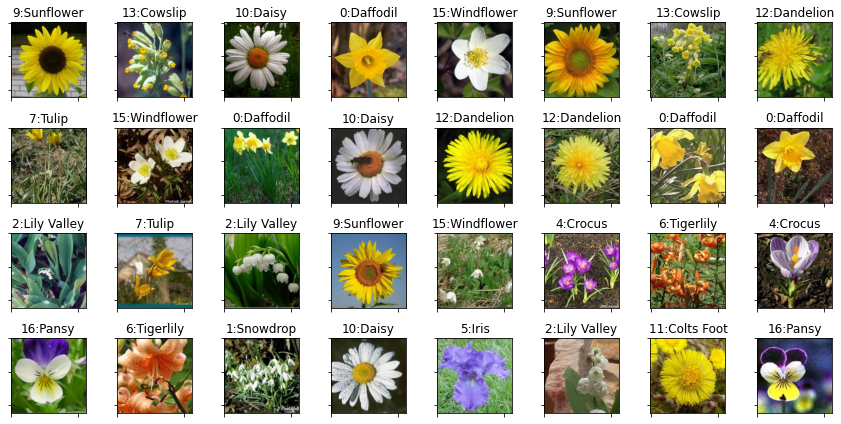

In [10]:
# creamos cargador
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # número de procesos paralelos
    num_workers=4
)
# desplegamos lote
batch = next(iter(trn_dl))
x, y, labels = batch['x'] , batch['y'], batch['label']
titles = [f'{v}:{l}' for v, l in zip(y, labels)]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, titles, ROWS, COLS)

x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


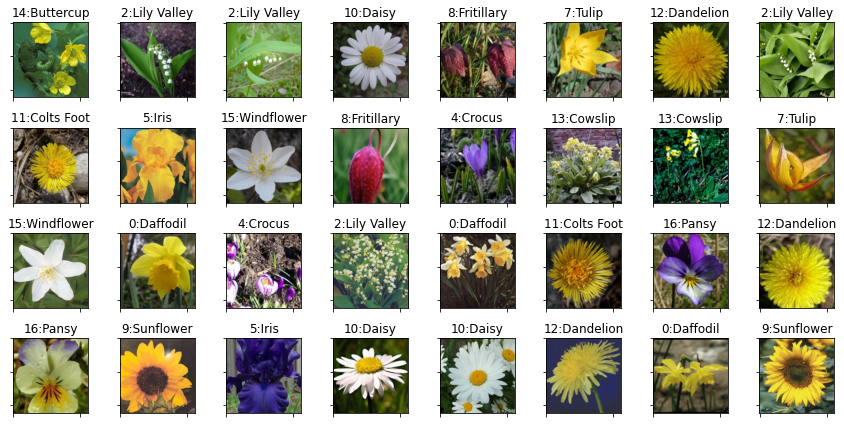

In [11]:
# creamos cargador
val_dl = DataLoader(
    # conjunto
    val_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # número de procesos paralelos
    num_workers=4
)
# desplegamos lote
batch = next(iter(val_dl))
x, y, labels = batch['x'] , batch['y'], batch['label']
titles = [f'{v}:{l}' for v, l in zip(y, labels)]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, titles, ROWS, COLS)

## 3. Modelo

Torchvision provee una familia de [modelos](https://pytorch.org/docs/1.6.0/torchvision/models.html#classification) preentrenados en ImageNet. Usaremos [Shufflenet V2](https://arxiv.org/abs/1807.11164), una arquitectura eficiente para clasificación de imágenes. 

### 3.1 Carga de pesos

In [12]:
# instancia de modelo y carga de pesos
model = tvm.shufflenet_v2_x0_5(pretrained=True)
model

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

### 3.3 Transferencia de conocimiento

In [13]:
# congelamos los parámetros
for param in model.parameters():
    # no participa en la retropropagación
    param.requires_grad = False
# congelamos las estadísticas
model.eval()

# remplazo de última capa
model.fc = nn.Linear(1024, 17)

# inspección
summary(model, (1, 3, IMG_SIZE, IMG_SIZE), 
        device='cpu', verbose=0)

/home/richardt/.miniconda3/envs/cap/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
ShuffleNetV2                             --                        --
├─Sequential: 1-1                        [1, 24, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 24, 112, 112]         (648)
│    └─BatchNorm2d: 2-2                  [1, 24, 112, 112]         (48)
│    └─ReLU: 2-3                         [1, 24, 112, 112]         --
├─MaxPool2d: 1-2                         [1, 24, 56, 56]           --
├─Sequential: 1-3                        [1, 48, 28, 28]           --
│    └─InvertedResidual: 2-4             [1, 48, 28, 28]           --
│    │    └─Sequential: 3-1              [1, 24, 28, 28]           (888)
│    │    └─Sequential: 3-2              [1, 24, 28, 28]           (1,512)
│    └─InvertedResidual: 2-5             [1, 48, 28, 28]           --
│    │    └─Sequential: 3-3              [1, 24, 28, 28]           (1,512)
│    └─InvertedResidual: 2-6             [1, 48, 28, 28]           

## 4. Entrenamiento
<!-- <img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/figs/comida_entrenamiento.svg" width="650" /> -->

### 4.1 Funciones de entrenamiento

In [14]:
def train_epoch(dl, model, opt, device):
    """Entrena una época"""
    # entrenamiento de una época
    for batch in dl:
        x = batch['x'].to(device)
        y_true = batch['y'].to(device)
        # computamos logits
        y_lgts = model(x)
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actualizamos parámetros
        opt.step()

def eval_epoch(dl, model, device, num_batches=None):
    """Evalua una época"""
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():
        
        losses, accs = [], []
        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for batch in take(dl, num_batches):
            x = batch['x'].to(device)
            y_true = batch['y'].to(device)
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # computamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100
        
        return loss, acc

def save_check_point(model, epoch, run_dir):
    """Guarda un punto de control."""
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
        }, 
        join(run_dir, 'weights.pth')
    )

def train(model, trn_dl, val_dl,
          trn_writer, val_writer, epochs,
          trn_batches=None, val_batches=None):

    # optimizador
    opt = optim.Adam(model.parameters(), lr=1e-3)

    # usamos GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # movemos a dispositivo
    model.to(device)
    
    # modelo en modo de evaluación
    # para transferencia de conocimiento además de congelar los pesos, 
    # es importante congelar las estadísticas σ y μ 
    model.eval()

    # ciclo de entrenamiento
    best_acc = 0
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt, device)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, device, trn_batches)
        # registramos trazas de TB 
        trn_writer.add_scalar('metrics/loss', trn_loss, epoch)
        trn_writer.add_scalar('metrics/acc', trn_acc, epoch)

        # evaluamos la época en validación
        val_loss, val_acc = eval_epoch(val_dl, model, device, val_batches)
        # registramos trazas de TB
        val_writer.add_scalar('metrics/loss', val_loss, epoch)
        val_writer.add_scalar('metrics/acc', val_acc, epoch)

        
        # pseudo paro temprano: si hay mejora guardamos punto de control
        if val_acc > best_acc:
            best_acc = val_acc
            save_check_point(model, epoch, run_dir)

### 4.2 Monitoreo con Tensorboard

In [15]:
# directorio de la corrida
run_dir = join('runs', 'flowers17', timestamp())
run_dir

'runs/flowers17/211007T184033'

In [16]:
# escritor de trazas
trn_writer = SummaryWriter(join(run_dir, 'trn'))
val_writer = SummaryWriter(join(run_dir, 'val'))

In [17]:
# inspeccionemos el directorio de la corrida
!ls -R {run_dir}

runs/flowers17/211007T184033:
trn  val

runs/flowers17/211007T184033/trn:
events.out.tfevents.1633650033.rlyeh.133126.0

runs/flowers17/211007T184033/val:
events.out.tfevents.1633650033.rlyeh.133126.1


In [18]:
# lanzamos Tensorboard
%load_ext tensorboard
%tensorboard --logdir runs/flowers17 --host localhost

In [19]:
# entrenamos modelo
train(model, trn_dl, val_dl, trn_writer, val_writer, 
      epochs=20, trn_batches=5, val_batches=5)

  0%|          | 0/20 [00:00<?, ?it/s]

In [20]:
# inspeccionemos el directorio de la corrida
!ls -R {run_dir}

runs/flowers17/211007T184033:
trn  val  weights.pth

runs/flowers17/211007T184033/trn:
events.out.tfevents.1633650033.rlyeh.133126.0

runs/flowers17/211007T184033/val:
events.out.tfevents.1633650033.rlyeh.133126.1


## 5. Evaluación

### 5.1 Cargando modelo

In [21]:
# cargamos el punto de contral
ckpt = torch.load(join(run_dir, 'weights.pth'))
# imprimimos la mejor época
best_epoch = ckpt['epoch']
print(f'Best epoch {best_epoch}')

Best epoch 15


In [22]:
# instanciamos un modelo vacio
model = tvm.shufflenet_v2_x0_5()
model.fc = nn.Linear(1024, 17)

# cargamos pesos
state_dict = ckpt['model_state_dict']
model.load_state_dict(state_dict)

# congelamos las estadísticas
_ = model.eval()

### 5.2 Conjunto y cargador de prueba

In [23]:
# conjunto
tst_ds = Flowers17(DATA_DIR, 1, 'tst', transform=val_tsfm)
# cargador
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # número de procesos paralelos
    num_workers=4
)
len(tst_ds)

340

### 5.3 Evaluación Final 

In [24]:
device = torch.device('cpu')
trn_loss, trn_acc = eval_epoch(trn_dl, model, device)
val_loss, val_acc = eval_epoch(val_dl, model, device)
tst_loss, tst_acc = eval_epoch(tst_dl, model, device)

In [25]:
print(f'ac trn={trn_acc:5.2f} val={val_acc:5.2f} tst={tst_acc:5.2f}')

ac trn=93.75 val=92.61 tst=89.43


In [26]:
print(f'loss trn={trn_loss:6.2f} val={val_loss:6.2f} tst={tst_loss:6.2f}')

loss trn=167.01 val=173.15 tst=170.44


### 5.4 Inspección visual de resultados

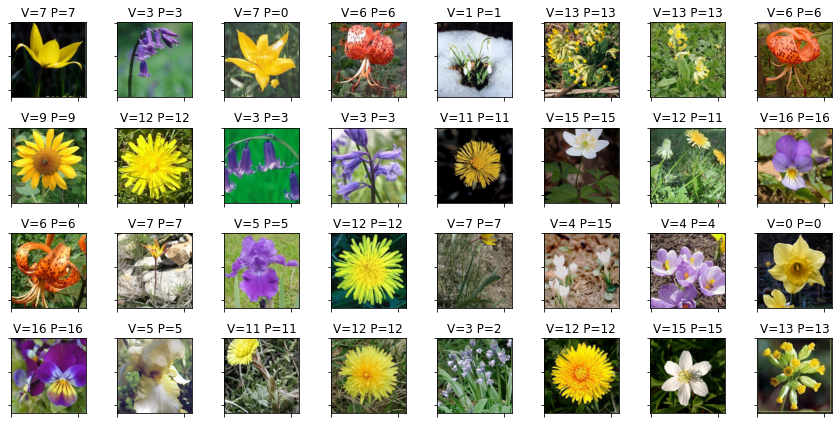

In [27]:
with torch.no_grad():
    batch = next(iter(tst_dl))
    x, y_true = batch['x'], batch['y']
    y_pred = torch.argmax(F.softmax(model(x), 1), 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x, titles, ROWS, COLS)

## 6. Participación

Enriquece el proceso de aumentado de datos agregando un corte aleatorio. Para esto, modifica la transformación de entrenamiento realizando los siguientes pasos:

1. Modifica la línea `T.Resize(IMG_SIZE)` para que la imagen redimensionada sea 1.25 veces `IMG_SIZE`.
2. Enseguida agrega un corte aletorio usando la trasformación [`RandomCrop`](https://pytorch.org/docs/1.6.0/torchvision/transforms.html#torchvision.transforms.RandomCrop).

## 7. Participación

Descomenta las líneas de código en la siguiente celda y correla.

* ¿Qué pasa con las evaluaciones finales?
* ¿Por qué crees que se da este comportamiento? 

In [28]:
# model = tvm.shufflenet_v2_x0_5()
# model.fc = nn.Linear(1024, 17)

# state_dict = ckpt['model_state_dict']
# model.load_state_dict(state_dict)

# trn_loss, trn_acc = eval_epoch(trn_dl, model, device)
# val_loss, val_acc = eval_epoch(val_dl, model, device)
# tst_loss, tst_acc = eval_epoch(tst_dl, model, device)

# print(f'acc trn={trn_acc:5.2f} val={val_acc:5.2f} tst={tst_acc:5.2f}')
# print(f'loss trn={trn_loss:6.2f} val={val_loss:6.2f} tst={tst_loss:6.2f}')